In [ ]:
%%capture
!pip install qutip
!pip install tqdm

In [ ]:
from qutip import *
from qutip import Qobj, Options, mesolve
import qutip as q
import numpy as np
import scipy
from scipy.integrate import cumulative_trapezoid as cumtrapz
from scipy.optimize import curve_fit
from numpy import pi, exp, sqrt, linspace, zeros, logspace, sin, cos, array, tan
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

In [ ]:
#Характерные времена
norm = 1e6

T_3E_life_time = 13*1e-9 *norm  # 13нс
T_1E_life_time = 170*1e-9 *norm# 170нс
T2_star =        0.4*1e-6 *norm# 0.4мкс
T1 =             5*1e-3 *norm  # 5мс

pi2 = 2 * pi

In [ ]:
# Скорости

G_T1 = 1./T1 *pi2
G_T2_star = 1./T2_star
G_T_1E = 1./T_1E_life_time *pi2
G_T_3E = 1./T_3E_life_time *pi2

In [ ]:
# Define the states: |0>, |-1>, |+1>, |e0>, |e-1>, |e+1>, |s>
N = 7
ground_states = [basis(N, i) for i in range(N)]

In [ ]:
# H(ΩR, Δ - detune) -> Qobg(H)

def H(Omega_R, Delta=0):
  H = Delta * pi2 * (ground_states[1] * ground_states[1].dag() + ground_states[2] * ground_states[2].dag())
  H = H + Omega_R/2 * pi2 * (ground_states[0] * ground_states[1].dag() + ground_states[1] * ground_states[0].dag())
                      # + ground_states[0] * ground_states[2].dag() + ground_states[2] * ground_states[0].dag())

  return H

In [ ]:
# H_mod(ΩR, Ωm, deep, Delta) -> Qobg(H_modulate), dict(args)

def H_mod(Omega_R, Ωm, d=0, Delta=0):
  H0 = H(Omega_R, Delta)
  H1 = d * pi2 * (ground_states[1] * ground_states[1].dag() )

  args = {'Wm': Ωm * pi2}
  H_modulate = [H0, [H1, 'cos(Wm * t)']]

  return H_modulate, args

In [ ]:
# create_operator(index_to, index_from, g = 1) -> Qobj(L)

def create_operator(index_to, index_from, g = 1):
  L = sqrt(g) * ground_states[index_to] * ground_states[index_from].dag()
  return L

$$\frac{d}{dt}p_0 = -2\gamma p_0 + \gamma p_{-1} + \gamma p_{p+1}$$
$$\frac{d}{dt}p_{-1} = -\gamma p_{-1} + \gamma p_{0}$$
$$\frac{d}{dt}p_{+1} = - \gamma p_{+1} + \gamma p_{0}$$

$$p_0 + p_{-1} + p_{+1} = 1$$

$$\frac{d}{dt}p_0 = -2\gamma p_0 + \gamma (1-p_0)$$

$$\frac{d}{dt}p_0 + 3\gamma p_0= \gamma$$

$$p_0(t) = (p_0(0) - \frac{1}{3})  exp(-3\gamma t) + \frac{1}{3}$$

In [ ]:
#collaps_operators(s_parametr) -> list(c_ops)

def collaps_operators(s):

  # T1 relaxation (|-1><0|, |0><-1|, |+1><0|, |0><+1|)
  L_T1_1 = create_operator(0, 1, G_T1/3)
  L_T1_2 = create_operator(1, 0, G_T1/3)
  L_T1_3 = create_operator(0, 2, G_T1/3)
  L_T1_4 = create_operator(2, 0, G_T1/3)

  # Optical pumping (|e0><0|, |e-1><-1|, |+1><e+1|)
  L_opt_1 = create_operator(3, 0, G_T_3E * s)
  L_opt_2 = create_operator(4, 1, G_T_3E * s)
  L_opt_3 = create_operator(5, 2, G_T_3E * s)

  # Decay from excited states (|0><e0|, |-1><e-1|, |+1><e+1|)
  L_decay_1 = create_operator(0, 3, G_T_3E)
  L_decay_2 = create_operator(1, 4, G_T_3E * 0.7)
  L_decay_3 = create_operator(2, 5, G_T_3E * 0.7)

  # Decay from |e-1>,|e+1> to |s>
  L_e1_s_1 = create_operator(6, 4, G_T_3E * 0.3)
  L_e1_s_2 = create_operator(6, 5, G_T_3E * 0.3)

  # Decay from |s> to ground states (equal probability)
  L_s_g0 = create_operator(0, 6, G_T_1E * 0.8)
  L_s_gm1 = create_operator(1, 6, G_T_1E * 0.1)
  L_s_gp1 = create_operator(2, 6, G_T_1E * 0.1)

  # Dephasing (|0><0| - |1><1|)
  L_T2_star_1 = np.sqrt(G_T2_star/3) * (ground_states[0] * ground_states[0].dag() -
                                  ground_states[1] * ground_states[1].dag())

  L_T2_star_2 = np.sqrt(G_T2_star/3) * (ground_states[0] * ground_states[0].dag() -
                                  ground_states[2] * ground_states[2].dag())

  L_T2_star_3 = np.sqrt(G_T2_star/3) * (ground_states[1] * ground_states[1].dag() -
                                  ground_states[2] * ground_states[2].dag())

  c_ops = [L_T1_1, L_T1_2, L_T1_3, L_T1_4,
           L_opt_1, L_opt_2, L_opt_3,
           L_decay_1, L_decay_2, L_decay_3,
           L_e1_s_1, L_e1_s_2,
           L_s_g0, L_s_gm1, L_s_gp1,
           L_T2_star_1, L_T2_star_2, L_T2_star_3]

  return c_ops

In [ ]:
# Get_equilibrium(level, ΩR, s_parametr, Δ=0) -> int(population)

def Get_equilibrium(level_name, ΩR, s, Delta=0):

    c_ops = collaps_operators(s)

    rho = q.steadystate(H(ΩR, Delta), c_ops)

    level_index = {'0': 0, '-1': 1, '+1': 2, 'e0': 3, 'e-1': 4, 'e+1': 5, 's': 6}[level_name]
    population = rho[level_index, level_index].real

    return population

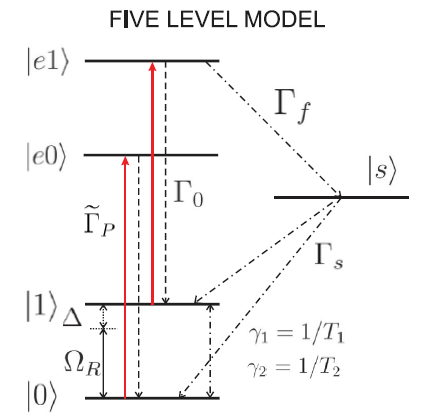

# Населённость от ΩR и от s-параметра

In [ ]:
level = '0'  # Can be '0', '-1', '+1', 'e0', 'e-1', 'e+1', 's'

ΩR = 1
s = 0# 1e-3
population = Get_equilibrium(level, ΩR, s)
print(f"Населённость уровня |{level}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ",population)

Населённость уровня |0> при параметре насыщения s=0 и частоте Раби ΩR=1 MHz:  0.3333333333335153


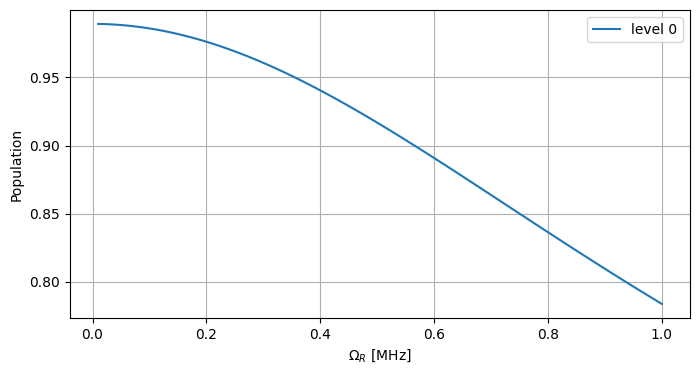

In [ ]:
level = '0'
s = 0.01
ΩR_mas = linspace(0.01*1e6, 1*1e6, 100)/norm
populations = []

for ΩR in ΩR_mas:
  populations.append(Get_equilibrium(level, ΩR, s))


plt.figure(figsize=(8, 4))
plt.plot(ΩR_mas, populations,  label = f'level {level}')
plt.xlabel('$\Omega_R$ [MHz]')
plt.ylabel(f'Population')
plt.legend()
plt.grid(True)
plt.show()

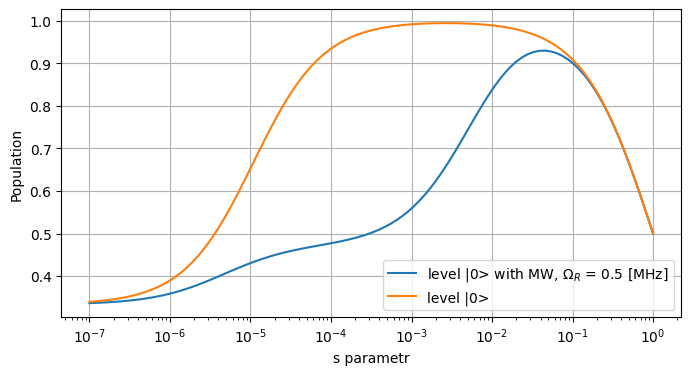

In [ ]:
level = '0'
ΩR = 0.5 * 1e6/norm
s_mas = logspace(-7, 0, 100)

populations_MW = []
populations_no_MW = []

for s in s_mas:
  populations_MW.append(Get_equilibrium(level, ΩR, s))
  populations_no_MW.append(Get_equilibrium(level, 0, s))


plt.figure(figsize=(8, 4))
plt.plot(s_mas, populations_MW,  label = f'level |{level}> with MW, $\Omega_R$ = {ΩR} [MHz]')
plt.plot(s_mas, populations_no_MW,  label = f'level |{level}>')
plt.xlabel('s parametr')
plt.ylabel(f'Population')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Contrast

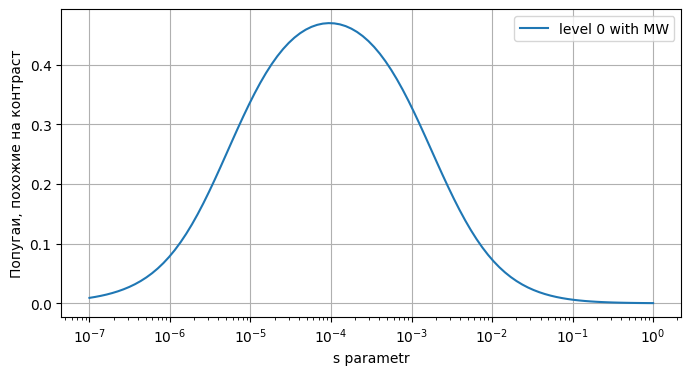

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(s_mas, (np.array(populations_no_MW) - np.array(populations_MW))/np.array(populations_no_MW),  label = f'level {level} with MW')
plt.xlabel('s parametr')
plt.ylabel(f'Попугаи, похожие на контраст')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

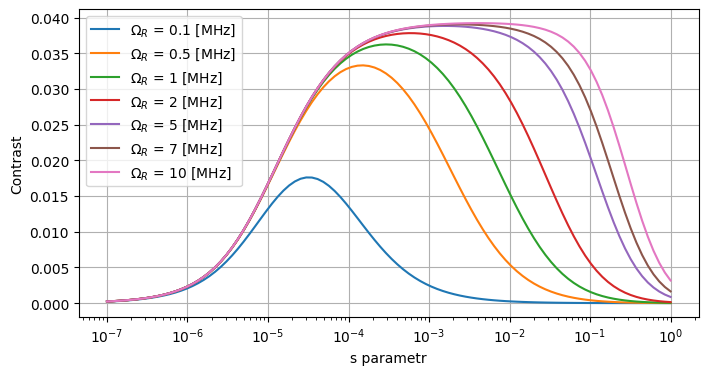

In [ ]:
level = '0'
ΩR = 0.5 * 1e6/norm
s_mas = logspace(-7, 0, 100)
ΩR_mas = [0.1, 0.5, 1, 2, 5, 7, 10]

plt.figure(figsize=(8, 4))

for ΩR in ΩR_mas:
  contrast_slice = []
  for s in s_mas:
    contrast_slice.append((Get_equilibrium('0', 0, s) - Get_equilibrium('0', ΩR, s)) * 0.075)
  plt.plot(s_mas, contrast_slice,  label = f'$\Omega_R$ = {ΩR} [MHz]')

plt.xlabel('s parametr')
plt.ylabel(f'Contrast')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ΩR_mas = np.linspace(0.1, 2, 200)
s_mas = np.logspace(-6, -1, 200)

contrast = np.zeros((len(s_mas), len(ΩR_mas)))

progress_bar = tqdm(total=len(ΩR_mas) * len(s_mas), desc="Общий прогресс цикла")

for i, s in enumerate(s_mas):
  for j, ΩR in enumerate(ΩR_mas):
    R1 = Get_equilibrium('0', ΩR, s)
    R0 = Get_equilibrium('0', 0, s)
    contrast[i,j] = (R0-R1) * 0.075

    progress_bar.update(1)

progress_bar.close()

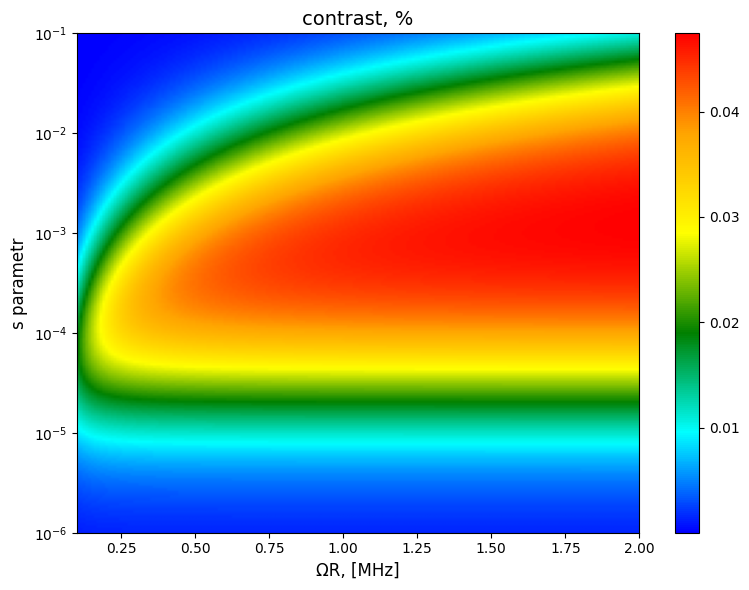

In [ ]:
plt.figure(figsize=(8, 6))
colors = ["blue", "cyan", "green", "yellow", "orange", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.imshow(contrast,
           extent=[ΩR_mas.min(), ΩR_mas.max(), np.log10(s_mas.min()), np.log10(s_mas.max())],
           aspect='auto',
           origin='lower',
           cmap=cmap)

plt.colorbar()
plt.xlabel('ΩR, [MHz]', fontsize=12)
plt.ylabel('s parametr', fontsize=12)

ax = plt.gca()
y_ticks = np.arange(-6, 0)
ax.set_yticks(y_ticks)
ax.set_yticklabels([f"$10^{{{i}}}$" for i in y_ticks])

plt.title(f'contrast, %', fontsize=14)
plt.tight_layout()
plt.show()

#Lindblad(ΩR, Ωm, deep, time array, level, s_parametr,  Δ=0) -> list(p(t0), p(t1), ...)

In [ ]:
# Lindblad(ΩR, Ωm, deep, time array, level, s_parametr,  Δ=0, rho_ini=q.basis(7, 0)) -> list(p(t0), p(t1), ...)
def Lindblad(Omega_R, Ωm, d, tlist, level, s, Delta=0, Prog_bar = True, rho_ini=q.basis(7, 0), level2 = "Nemo"):

  if level2 == "Nemo": level2=level

  H = H_mod(Omega_R, Ωm, d, Delta)[0]
  psi0 = Qobj(rho_ini)
  c_ops = collaps_operators(s)
  args = H_mod(Omega_R, Ωm, d, Delta)[1]

  level_index = {'0': 0, '-1': 1, '+1': 2, 'e0': 3, 'e-1': 4, 'e+1': 5, 's': 6}[level]
  level2_index = {'0': 0, '-1': 1, '+1': 2, 'e0': 3, 'e-1': 4, 'e+1': 5, 's': 6}[level2]

  if Prog_bar: options = {"nsteps": 1e6, "progress_bar": "tqdm"}
  else: options={"nsteps": 1e6}

  result = mesolve(H,
                  psi0,
                  tlist,
                  c_ops=c_ops,
                  e_ops=[create_operator(level_index, level2_index)],
                  args=args,
                  options=options
                  )

  return result.expect[0]

#Тесты, проверяем, что в модели всё работает корректно

## Проверка T1

In [ ]:
def collaps_operators(s):

  # T1 relaxation (|-1><0|, |0><-1|, |+1><0|, |0><+1|)
  L_T1_1 = create_operator(0, 1, G_T1/3)
  L_T1_2 = create_operator(1, 0, G_T1/3)
  L_T1_3 = create_operator(0, 2, G_T1/3)
  L_T1_4 = create_operator(2, 0, G_T1/3)


  c_ops = [L_T1_1, L_T1_2, L_T1_3, L_T1_4]

  return c_ops

[1/1] Cythonizing qtcoeff_f8e252e4cf0d8e8d267a64f337a2f3.pyx


INFO:root:running build_ext
INFO:root:building 'qtcoeff_f8e252e4cf0d8e8d267a64f337a2f3' extension
INFO:root:creating build/temp.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-g++ -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -fPIC -I/usr/local/lib/python3.11/dist-packages/qutip/core/data -I/usr/local/lib/python3.11/dist-packages/numpy/_core/include -I/usr/include/python3.11 -c qtcoeff_f8e252e4cf0d8e8d267a64f337a2f3.cpp -o build/temp.linux-x86_64-cpython-311/qtcoeff_f8e252e4cf0d8e8d267a64f337a2f3.o -w -O3 -funroll-loops
INFO:root:creating build/lib.linux-x86_64-cpython-311
INFO:root:x86_64-linux-gnu-g++ -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -shared -Wl,-O1 -Wl,-Bsymbolic-functions build/temp.linux-x86_64-cpython-311/qtcoeff_f8e252e4cf0d8e8d267a64f337a2f3.o -L/usr/lib/x86_64-linux-gnu -o build/lib.linux-x86_64-cpython-311/qtcoe

  0%|          | 0/1000 [00:00<?, ?it/s]

Населённость уровня |0> при параметре насыщения s=0 и частоте Раби ΩR=0 MHz:  0.3333
Параметры фита:
c1 = 0.3333, c2 = 0.6667, c3 = 0.00125663


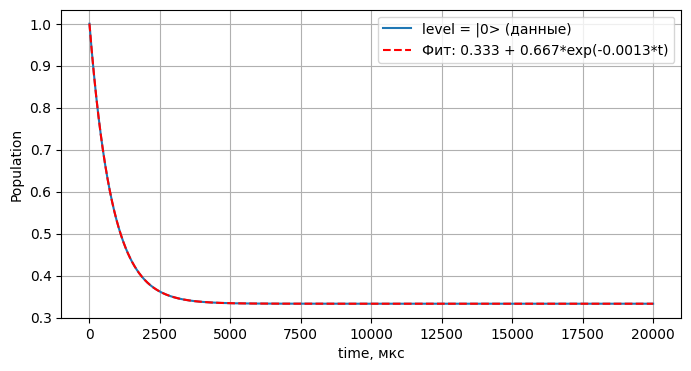

In [ ]:
from scipy.optimize import curve_fit

def exp_func(t, c1, c2, c3):
    return c1 + c2 * np.exp(-c3 * t)


level = '0'
ΩR = 0
Ωm = 0
deep = 0
s = 0
Δ = 0
tlist = np.linspace(0, 20000, 1001)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ)

p0 = [1/3, 2/3, 0.0002]
popt, pcov = curve_fit(exp_func, tlist, occupations, p0=p0)
c1, c2, c3 = popt

y_fit = exp_func(tlist, *popt)

#population = Get_equilibrium(level, ΩR, s)
print(f"Населённость уровня |{level}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ", round(population, 4))
print("Параметры фита:")
print(f"c1 = {c1:.4f}, c2 = {c2:.4f}, c3 = {c3:.8f}")

plt.figure(figsize=(8, 4))
plt.plot(tlist, occupations, label=f'level = |{level}> (данные)')
plt.plot(tlist, y_fit, 'r--', label=f'Фит: {c1:.3f} + {c2:.3f}*exp(-{c3:.4f}*t)')
plt.xlabel('time, мкс')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
G_T1

0.0012566370614359172

  0%|          | 0/100 [00:00<?, ?it/s]

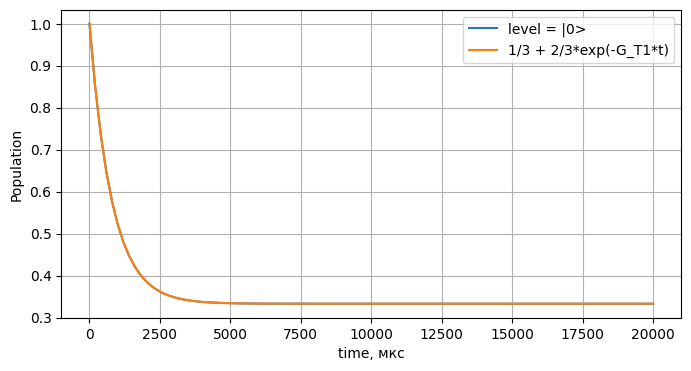

In [ ]:
level = '0'

ΩR = 0
Ωm = 0
deep = 0
s = 0
Δ = 0
tlist = linspace(0, 20000, 101)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ)


#population = Get_equilibrium(level, ΩR, s)
#print(f"Населённость уровня |{level}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ",round(population, 4))

#y = 1/3 + 2/3 * exp(-0.0006 * tlist)
y = 1/3 + 2/3 * exp(-G_T1 * tlist)

plt.figure(figsize=(8, 4))
plt.plot(tlist, occupations, label = f'level = |{level}>')
plt.plot(tlist, y, label = f"1/3 + 2/3*exp(-G_T1*t)")
plt.xlabel('time, мкс')
plt.ylabel(f'Population')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

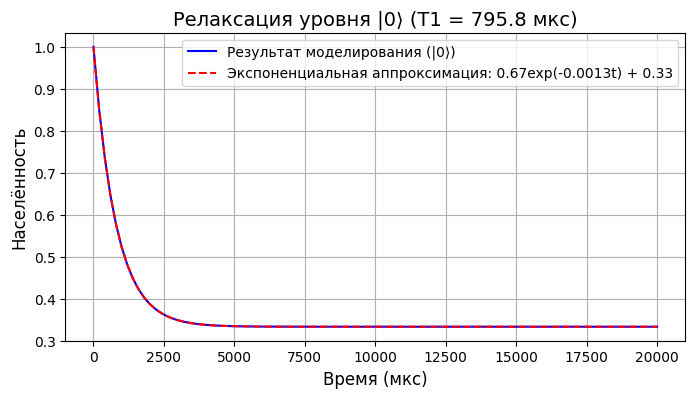

Оценка T1 из аппроксимации: 5000.0 мкс
Теоретическое значение T1: 5000.0 мкс


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

level = '0'
ΩR = 0
Ωm = 0
deep = 0
s = 0
Δ = 0
tlist = np.linspace(0, 20000, 101)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ)
#population = Get_equilibrium(level, ΩR, s)

def exp_decay(t, A, gamma, C):
    return A * exp(-gamma * t) + C

# Начальные предположения для параметров
p0 = [2/3, G_T1, 1/3]  # A, γ, C

# Аппроксимируем данные
params, _ = curve_fit(exp_decay, tlist, occupations, p0=p0)
A_fit, gamma_fit, C_fit = params

y = exp_decay(tlist, A_fit, gamma_fit, C_fit)

plt.figure(figsize=(8, 4))
plt.plot(tlist, occupations, 'b-', label=f'Результат моделирования (|{level}⟩)')
plt.plot(tlist, y, 'r--', label=f'Экспоненциальная аппроксимация: {A_fit:.2f}exp(-{gamma_fit:.4f}t) + {C_fit:.2f}')
plt.xlabel('Время (мкс)', fontsize=12)
plt.ylabel('Населённость', fontsize=12)
plt.title(f'Релаксация уровня |{level}⟩ (T1 = {1/gamma_fit:.1f} мкс)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

print(f"Оценка T1 из аппроксимации: {1/(gamma_fit/pi2) :.1f} мкс")
print(f"Теоретическое значение T1: {T1:.1f} мкс")
#print(f"Равновесная населённость: {population:.4f}")

## Проверка T_3E_life_time

In [ ]:
def collaps_operators(s):

  # Optical pumping (|e0><0|, |e-1><-1|, |+1><e+1|)
  L_opt_1 = create_operator(3, 0, G_T_3E * s)
  L_opt_2 = create_operator(4, 1, G_T_3E * s)
  L_opt_3 = create_operator(5, 2, G_T_3E * s)

  # Decay from excited states (|0><e0|, |-1><e-1|, |+1><e+1|)
  L_decay_1 = create_operator(0, 3, G_T_3E)
  L_decay_2 = create_operator(1, 4, G_T_3E * 0.7)
  L_decay_3 = create_operator(2, 5, G_T_3E * 0.7)

  # Decay from |e-1>,|e+1> to |s>
  L_e1_s_1 = create_operator(6, 4, G_T_3E * 0.3)
  L_e1_s_2 = create_operator(6, 5, G_T_3E * 0.3)



  c_ops = [
           L_opt_1, L_opt_1, L_opt_1,
           L_decay_1, L_decay_2, L_decay_3,
           L_e1_s_1, L_e1_s_2
           ]

  return c_ops

Здесь обращаю внимание, что мы в Lindblad явно указываем, что изначально вся населённость на |e0>, по дефолту, если не задать параметр rho_ini населённость на |0>

  0%|          | 0/100 [00:00<?, ?it/s]

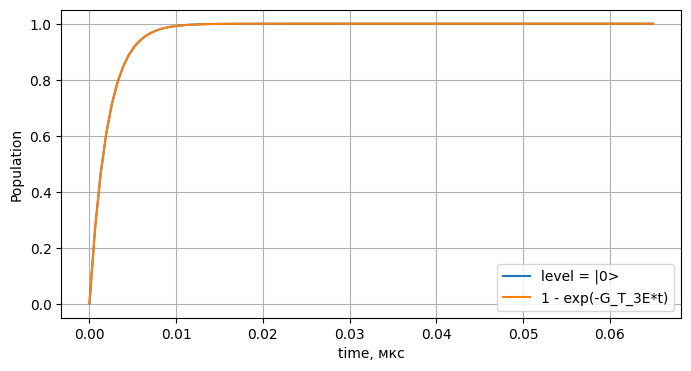

In [ ]:
level = '0'

ΩR = 0.
Ωm = 0
deep = 0
s = 0.
Δ = 0
tlist = linspace(0, 5*T_3E_life_time, 101)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ, rho_ini=Qobj(create_operator(3, 3)))

y = 1 - exp(-G_T_3E * tlist)

plt.figure(figsize=(8, 4))
plt.plot(tlist, occupations, label = f'level = |{level}>')
plt.plot(tlist, y, label = f"1 - exp(-G_T_3E*t)")
plt.xlabel('time, мкс')
plt.ylabel(f'Population')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

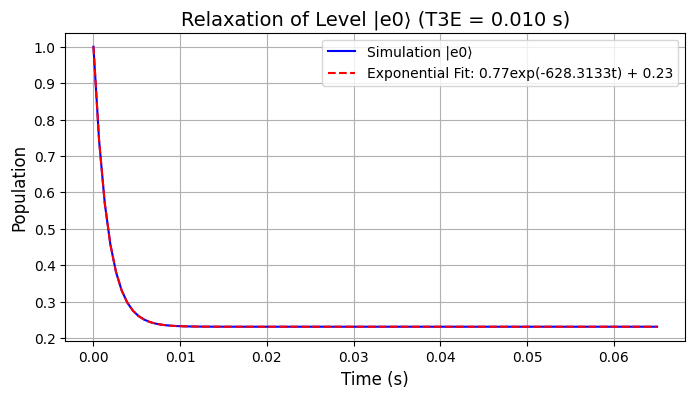

T3E from fit: 0.01000 s
Theoretical T3E: 0.013 s


In [ ]:
import scipy.optimize as opt
def exp_decay(t, A, gamma, C):
    return A * np.exp(-gamma * t) + C

level = 'e0'
ΩR = 0
Ωm = 0
deep = 0
s = 0.1
Δ = 0
tlist = np.linspace(0, 5*T_3E_life_time, 101)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ, rho_ini=Qobj(create_operator(3, 3)))


p0 = [0.5, G_T_3E, 0.5]  # A, γ, C

params, covariance = opt.curve_fit(exp_decay, tlist, occupations, p0=p0, maxfev=10000)
A_fit, gamma_fit, C_fit = params

T3E_fit = 1/(gamma_fit/pi2)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(tlist, occupations, 'b-', label=f'Simulation |{level}⟩')
plt.plot(tlist, exp_decay(tlist, A_fit, gamma_fit, C_fit), 'r--', label=f'Exponential Fit: {A_fit:.2f}exp(-{gamma_fit:.4f}t) + {C_fit:.2f}')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.title(f'Relaxation of Level |{level}⟩ (T3E = {T3E_fit:.3f} s)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

print(f"T3E from fit: {T3E_fit:.5f} s")
print(f"Theoretical T3E: {T_3E_life_time:.3f} s")
#print(f"Equilibrium Population: {population_eq:.4f}")

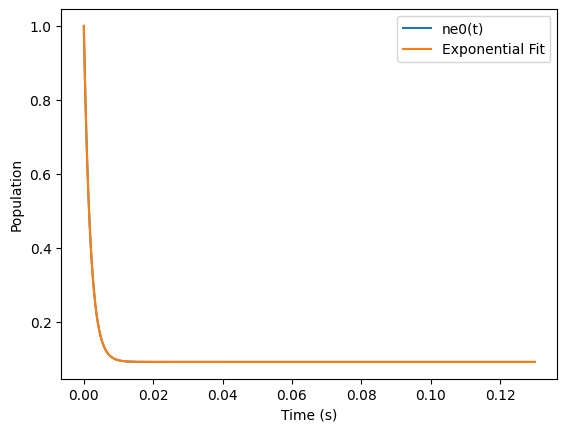

Effective G_T3E: 531.6541413231273
Effective T3E: 0.01181818181937345


In [ ]:
from scipy.integrate import odeint

def equations(y, t):
    n0, nm1, np1, ne0, nem1, nep1, ns = y
    dn0dt = - s*G_T_3E * n0 + G_T_3E * ne0 + 0.8*G_T_1E * ns
    dnm1dt = - s*G_T_3E * nm1 + 0.7*G_T_3E * nem1 + 0.1*G_T_1E * ns
    dnp1dt = - s*G_T_3E * np1 + 0.7*G_T_3E * nep1 + 0.1*G_T_1E * ns
    dne0dt = s*G_T_3E * n0 - G_T_3E * ne0
    dnem1dt = s*G_T_3E * nm1 - G_T_3E * nem1
    dnep1dt = s*G_T_3E * np1 - G_T_3E * nep1
    dnsdt = 0.3*G_T_3E * nem1 + 0.3*G_T_3E * nep1 - G_T_1E * ns
    return [dn0dt, dnm1dt, dnp1dt, dne0dt, dnem1dt, dnep1dt, dnsdt]

y0 = [0, 0, 0, 1, 0, 0, 0]

t = np.linspace(0, 10*T_3E_life_time, 500)

sol = odeint(equations, y0, t)

# Извлечение населенности уровня |e0>
ne0 = sol[:, 3]

# Аппроксимация экспонентой
def exp_decay(t, A, gamma, C):
    return A * np.exp(-gamma * t) + C

p0 = [1, G_T_3E, 0] # Initial guesses
params, covariance = opt.curve_fit(exp_decay, t, ne0, p0=p0)
A_fit, gamma_fit, C_fit = params

# Эффективная скорость распада
effective_rate = gamma_fit
effective_T3E = 1/(effective_rate/pi2)

# Визуализация
plt.plot(t, ne0, label='ne0(t)')
plt.plot(t, exp_decay(t, A_fit, gamma_fit, C_fit), label='Exponential Fit')
plt.xlabel('Time (s)')
plt.ylabel('Population')
plt.legend()
plt.show()

print(f"Effective G_T3E: {effective_rate}")
print(f"Effective T3E: {effective_T3E}")

## Проверка T2_star

  0%|          | 0/100 [00:00<?, ?it/s]

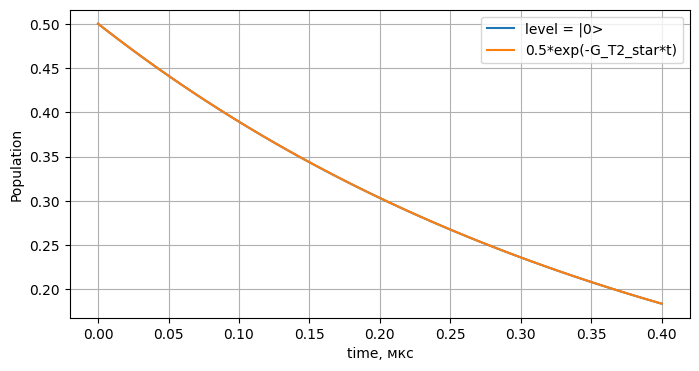

In [ ]:
level = '0'

ΩR = 0.1
Ωm = 0
deep = 0
s = 0.0
Δ = 0.
tlist = linspace(0, T2_star, 101)

A = zeros((7, 7))
A[0][0], A[1][1], A[0][1], A[1][0] = 0.5, 0.5, 0.5, 0.5

p0 = Lindblad(ΩR, Ωm, deep, tlist, '0', s, Δ, rho_ini=A, level2='-1')

p0 = array(p0)


y = 0.5*exp(-1./T2_star * tlist)

plt.figure(figsize=(8, 4))
plt.plot(tlist, p0, label = f'level = |{level}>')
plt.plot(tlist, y, label = f"0.5*exp(-G_T2_star*t)")
plt.xlabel('time, мкс')
plt.ylabel(f'Population')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

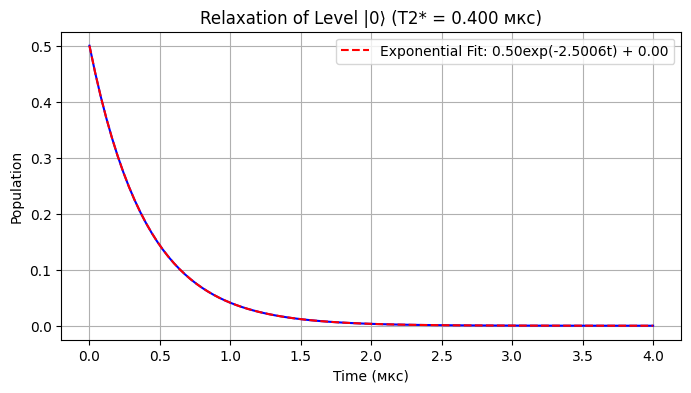

T2* from fit: 0.39990 
Theoretical T2*: 0.400 мкс


In [ ]:
import scipy.optimize as opt
def exp_decay(t, A, gamma, C):
    return A * np.exp(-gamma * t) + C

level = '0'
ΩR = 0.1
Ωm = 0
deep = 0
s = 0.
Δ = 0
tlist = np.linspace(0, 10*T2_star, 101)

A = zeros((7, 7))
A[0][0], A[1][1], A[0][1], A[1][0] = 0.5, 0.5, 0.5, 0.5

p = Lindblad(ΩR, Ωm, deep, tlist, '0', s, Δ, rho_ini=A, level2='-1')


P0 = [0.5, G_T2_star, 0]  # A, γ, C

params, covariance = opt.curve_fit(exp_decay, tlist, p, p0=P0, maxfev=10000)
A_fit, gamma_fit, C_fit = params

T2_star_fit = 1/(gamma_fit)

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(tlist, p, 'b-')
plt.plot(tlist, exp_decay(tlist, A_fit, gamma_fit, C_fit), 'r--', label=f'Exponential Fit: {A_fit:.2f}exp(-{gamma_fit:.4f}t) + {C_fit:.2f}')
plt.xlabel('Time (мкс)')
plt.ylabel('Population')
plt.title(f'Relaxation of Level |{level}⟩ (T2* = {T2_star_fit:.3f} мкс)')
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

print(f"T2* from fit: {T2_star_fit:.5f} ")
print(f"Theoretical T2*: {T2_star:.3f} мкс")
#print(f"Equilibrium Population: {population_eq:.4f}")

## Проверка Раби осцилляции

In [ ]:
def collaps_operators(s):

  # T1 relaxation (|-1><0|, |0><-1|, |+1><0|, |0><+1|)
  L_T1_1 = create_operator(0, 1, G_T1/3)
  L_T1_2 = create_operator(1, 0, G_T1/3)
  L_T1_3 = create_operator(0, 2, G_T1/3)
  L_T1_4 = create_operator(2, 0, G_T1/3)

  # Optical pumping (|e0><0|, |e-1><-1|, |+1><e+1|)
  L_opt_1 = create_operator(3, 0, G_T_3E * s)
  L_opt_2 = create_operator(4, 1, G_T_3E * s)
  L_opt_3 = create_operator(5, 2, G_T_3E * s)

  # Decay from excited states (|0><e0|, |-1><e-1|, |+1><e+1|)
  L_decay_1 = create_operator(0, 3, G_T_3E)
  L_decay_2 = create_operator(1, 4, G_T_3E * 0.7)
  L_decay_3 = create_operator(2, 5, G_T_3E * 0.7)

  # Decay from |e-1>,|e+1> to |s>
  L_e1_s_1 = create_operator(6, 4, G_T_3E * 0.3)
  L_e1_s_2 = create_operator(6, 5, G_T_3E * 0.3)

  # Decay from |s> to ground states (equal probability)
  L_s_g0 = create_operator(0, 6, G_T_1E * 0.8)
  L_s_gm1 = create_operator(1, 6, G_T_1E * 0.1)
  L_s_gp1 = create_operator(2, 6, G_T_1E * 0.1)

  c_ops = [L_T1_1, L_T1_2, L_T1_3, L_T1_4,
           L_opt_1, L_opt_2, L_opt_3,
           L_decay_1, L_decay_2, L_decay_3,
           L_e1_s_1, L_e1_s_2,
           L_s_g0, L_s_gm1, L_s_gp1]

  return c_ops

In [ ]:
# find_local_minimum(A) -> list(min1, min2, ...)

def find_local_minimum(A):
    local_minimum = []
    for i in range(len(A)-1):
      if A[i] < A[i - 1] and A[i] < A[i + 1]:
        local_minimum.append(i)

    return local_minimum

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Населённость уровня |0> при параметре насыщения s=0.0 и частоте Раби ΩR=0.5 MHz:  0.3333
Населённость уровня |-1> при параметре насыщения s=0.0 и частоте Раби ΩR=0.5 MHz:  0.3333
Населённость уровня |+1> при параметре насыщения s=0.0 и частоте Раби ΩR=0.5 MHz:  0.3333


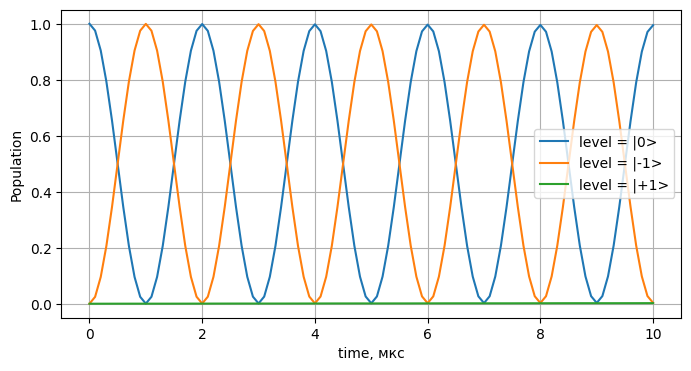

[10, 30, 50, 70, 90]
Частота Раби, оцененная по графику: 0.5 MHz
Частота Раби, заданная в эксперименте: 0.5 MHz


In [ ]:
level_0 = '0'
level_m1 = '-1'
level_p1 = '+1'

ΩR = 0.5
Ωm = 0
deep = 0
s = 0.
Δ = 0
tlist = linspace(0, 20*ΩR, 101)

p_0 =  Lindblad(ΩR, Ωm, deep, tlist, level_0,  s, Δ)
p_m1 = Lindblad(ΩR, Ωm, deep, tlist, level_m1, s, Δ)
p_p1 = Lindblad(ΩR, Ωm, deep, tlist, level_p1, s, Δ)


population_0 =  Get_equilibrium(level_0, ΩR, s)
population_m1 = Get_equilibrium(level_m1, ΩR, s)
population_p1 = Get_equilibrium(level_p1, ΩR, s)

print(f"Населённость уровня |{level_0}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ",round(population_0, 4))
print(f"Населённость уровня |{level_m1}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ",round(population_m1, 4))
print(f"Населённость уровня |{level_p1}> при параметре насыщения s={s} и частоте Раби ΩR={ΩR} MHz: ",round(population_p1, 4))


plt.figure(figsize=(8, 4))
plt.plot(tlist, p_0, label = f'level = |{level_0}>')
plt.plot(tlist, p_m1, label = f'level = |{level_m1}>')
plt.plot(tlist, p_p1, label = f'level = |{level_p1}>')
plt.xlabel('time, мкс')
plt.ylabel(f'Population')
plt.legend()
plt.grid(True)
plt.show()

print(find_local_minimum(p_0))
start_time, finish_time = find_local_minimum(p_0)[1], find_local_minimum(p_0)[2]
print(f"Частота Раби, оцененная по графику: {1./float(tlist[finish_time] - tlist[start_time])} MHz")
print(f"Частота Раби, заданная в эксперименте: {ΩR} MHz")

## Линейный скан частоты СВЧ поля при включенном лазере

In [ ]:
Sz = zeros((7, 7))
Sz[0][0], Sz[2][2] = 1, -1
Sz = Qobj(Sz)

Общий прогресс цикла: 100%|██████████| 5005/5005 [00:25<00:00, 200.00it/s]


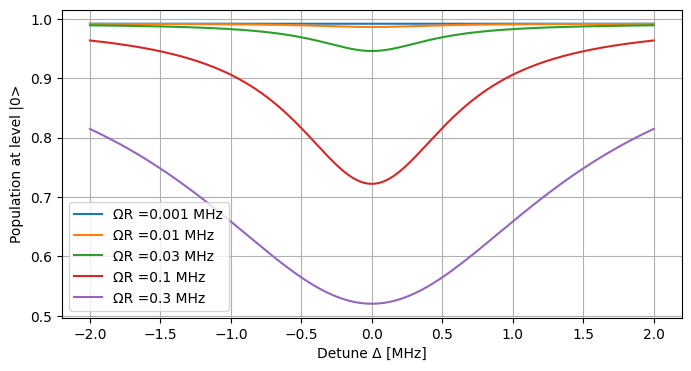

In [ ]:
level = '0'
s = 0.001
Δ_mas = linspace(-2, 2, 1001)
ΩR_mas = [0.001, 0.01, 0.03, 0.1, 0.3]
#ΩR_mas = logspace(-2,0,5)

total_steps = len(Δ_mas) * len(ΩR_mas)
progress_bar = tqdm(total=total_steps, desc="Общий прогресс цикла", position = 0)

plt.figure(figsize=(8, 4))
for ΩR in ΩR_mas:
  populations = []
  for Δ in Δ_mas:
    populations.append(Get_equilibrium(level, ΩR, s, Δ))
    progress_bar.update(1)
  plt.plot(array(Δ_mas), populations, label = f'ΩR ={ΩR} MHz')

progress_bar.close()


plt.xlabel('Detune Δ [MHz]')
plt.ylabel(f'Population at level |{level}>')
plt.legend()
plt.grid(True)
plt.show()




























# Рассчёт $dS/d\omega$

Смотрим зависимость населённости от времени

In [ ]:
# Смотрим зависимость населённости от времени
level = '0'

ΩR = 0.5
Ωm = 5 * 1e-3
deep = 0.5
s = 1e-3
Δ = 1
tlist = linspace(0, 1./Ωm * 5, 1001)

occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ)

  0%|          | 0/1000 [00:00<?, ?it/s]

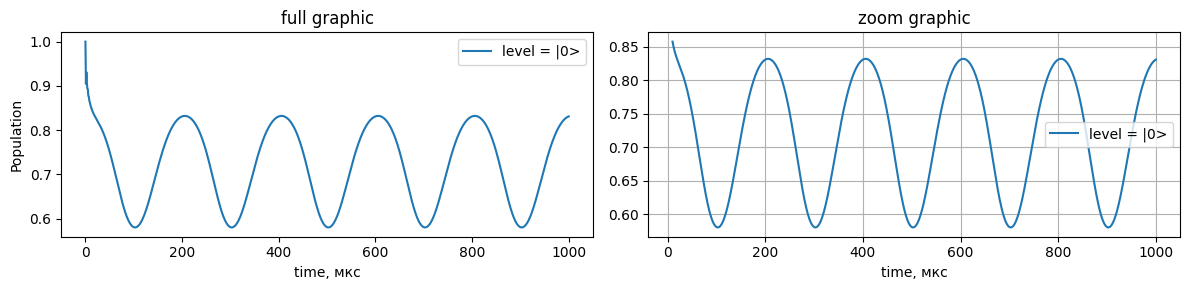

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Первый график
ax1.plot(tlist, occupations, label = f'level = |{level}>')
ax1.set_xlabel('time, мкс')
ax1.set_ylabel('Population')
ax1.set_title("full graphic")
ax1.legend()

# Второй график
ax2.plot(tlist[10:], occupations[10:], label = f'level = |{level}>')
ax2.set_xlabel('time, мкс')
ax2.set_title("zoom graphic")
ax2.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#@title find_local_minimum(A) -> list(min1, min2, ...)

def find_local_minimum(A):
    local_minimum = []
    for i in range(len(A)-1):
      if A[i] < A[i - 1] and A[i] < A[i + 1]:
        local_minimum.append(i)

    return local_minimum

In [ ]:
find_local_minimum(occupations)

[103, 303, 503, 703, 903]

Общий прогресс цикла: 100%|██████████| 25/25 [03:42<00:00,  8.89s/it]


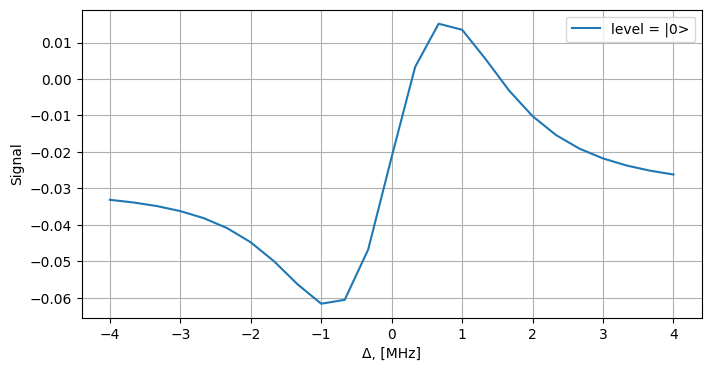

[np.float64(-0.033117284491459634), np.float64(-0.033839827896800956), np.float64(-0.03482967412053242), np.float64(-0.036206076609003), np.float64(-0.038144685112230875), np.float64(-0.04089421935180196), np.float64(-0.04476671573743929), np.float64(-0.050010658676570716), np.float64(-0.05632053752179964), np.float64(-0.06160357794875455), np.float64(-0.06053765841769043), np.float64(-0.04676335352056516), np.float64(-0.021394803555940776), np.float64(0.0033117275502025723), np.float64(0.01515963430980992), np.float64(0.013503070122361002), np.float64(0.005463348579181793), np.float64(-0.0031600554481708435), np.float64(-0.010179625104426025), np.float64(-0.01537217804101277), np.float64(-0.0191002314797755), np.float64(-0.021771551018345776), np.float64(-0.023704988555862134), np.float64(-0.025125355306536153), np.float64(-0.02618606934934066)]


In [ ]:
# Посмотрим на дисперсионный контур
level = '0'


ΩR = 0.5 * 1e6/norm
Ωm = 5 * 1e3/norm
s = 1e-2
Δ = 1 * 1e6/norm
tlist, dt= linspace(0, 4./Ωm , 201, retstep=True)

deep = 0.5
#deep_arr = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, ])

Δ_arr = linspace(-4, 4, 25)


total_steps = len(Δ_arr)
progress_bar = tqdm(total=total_steps, desc="Общий прогресс цикла", position = 0)


Signal = []
for Δ in Δ_arr:

  occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ, False)
  #plt.plot(tlist[8:], occupations[8:], label = f"Δ={Δ} MHz ")
  #loc_mins = find_local_minimum(occupations)
  t_start = 8#loc_mins[1]
  normirovka = 1./(tlist[-1] - tlist[t_start])

  x = tlist[t_start:]
  sig_mod = cos(x * Ωm*pi2)
  rho = occupations[t_start:]
  y = sig_mod * rho
  sig = normirovka * sum(y) * dt #cumtrapz(x, y, initial = 0)

  Signal.append(sig)
  progress_bar.update(1)

#plt.plot(tlist[t_start:], 0.5 + 0.1*cos(tlist[t_start:] * Ωm*pi2) )
# plt.legend()
# plt.grid(True)
# plt.show()

progress_bar.close()


plt.figure(figsize=(8, 4))
plt.plot(Δ_arr, Signal, label = f'level = |{level}>')
plt.xlabel('Δ, [MHz]')
plt.ylabel(f'Signal')
plt.legend()
plt.grid(True)
plt.show()
print(Signal)

In [ ]:
# Построим dSignal/dω
level = '0'


ΩR = 0.01
Ωm = 5*1e-3
s = 1e-2
Δ = 1
tlist, dt= linspace(0, 4./Ωm , 101, retstep=True)

#deep_arr = np.array([ 0.1, 0.5, 0.9, 1, 3, 5])
deep_arr = linspace(0.5, 1.5, 11)

Δ_arr = [-0.2, 0.2]
dΔ = Δ_arr[-1] - Δ_arr[0]
dSignal_dω = []

total_steps = len(Δ_arr) * len(deep_arr)
progress_bar = tqdm(total=total_steps, desc="Общий прогресс цикла", position = 0)

for deep in deep_arr:
  Signal = []
  for Δ in Δ_arr:

    occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s, Δ, False)
    #loc_mins = find_local_minimum(occupations)
    t_start = 10
    normirovka = 1./(tlist[-1] - tlist[t_start])

    x = tlist[t_start:]
    sig_mod = cos(x * Ωm*pi2)
    rho = occupations[t_start:]
    y = sig_mod * rho
    sig = normirovka * sum(y) * dt

    Signal.append(sig)
    progress_bar.update(1)

  dSignal_dω.append((Signal[-1] - Signal[0])/dΔ)

progress_bar.close()


Общий прогресс цикла: 100%|██████████| 22/22 [03:16<00:00,  8.92s/it]


In [ ]:
dSignal_dω

[np.float64(6.745416246268197e-05),
 np.float64(7.365900992177196e-05),
 np.float64(7.737699607645102e-05),
 np.float64(7.897811408068105e-05),
 np.float64(7.886999666111526e-05),
 np.float64(7.746041919255708e-05),
 np.float64(7.514269890291671e-05),
 np.float64(7.216409653225397e-05),
 np.float64(6.882024822847492e-05),
 np.float64(6.529154380546451e-05),
 np.float64(6.170346909624945e-05)]

s =0.01, ΩR = 0.01 MHz, Ωm = 5.0 kHz 


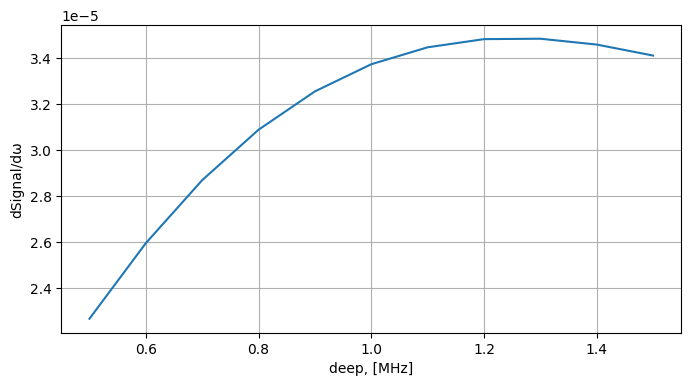

In [ ]:
print(f"s ={s}, ΩR = {ΩR} MHz, Ωm = {Ωm*1e3} kHz ")

plt.figure(figsize=(8, 4))
plt.plot(deep_arr, dSignal_dω)
plt.xlabel('deep, [MHz]')
plt.ylabel(f'dSignal/dω')
#plt.legend()
plt.grid(True)
#plt.xscale('log')
plt.show()

# Рассчёт чувствительности

In [ ]:
#@title s_parametr(el, P0=P0, n_nv=n_nv_minus, d_opt=d_opt):  ->float(s)

gamma = 28*1e3
sigma_nv = 2.8 * 1e-17 / 1e4       # см^2 -> м^2
c_conc = 1.75 * 1e20 *1e9          # мм^-3 -> м^-3
d_opt = 105 *1e-6                  # мкм -> м
phi = pi/6
h = 6.63 *1e-34                    # Дж * с
c = 3*1e8                          # м/c
E532 = h * c / (532 * 1e-9)
E670 = h * c / (670 * 1e-9)
kollection = 0.15
Gopt = 1./(13 * 1e-9)              #c^-1
n_nv_minus = 0.86 * 1e-6
P0 = 30 *1e-3                      #Вт

k = lambda n_nv: sigma_nv * c_conc * n_nv                   # коэффициент поглощения в алмазе
d = lambda d_opt, x_arg: d_opt + 2 * x_arg * tan(phi)       # диаметр лазерного пучка при распространении
P_beam =lambda P0, x_arg, n_nv: P0 * exp(-x_arg * k(n_nv))  # мощность пучка накачки
density = lambda P0, x_arg, n_nv, d_opt: 4/pi * P_beam(P0, x_arg, n_nv)/d(d_opt, x_arg)**2          # плотность мощности накачки

def s_parametr(el, P0=P0, n_nv=n_nv_minus, d_opt=d_opt):    #параметр насыщения
  s_param = density(P0, el, n_nv, d_opt) * sigma_nv / (E532 * Gopt)
  return s_param

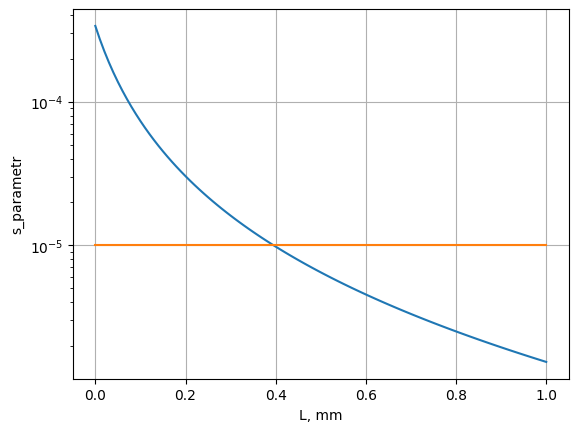

In [ ]:
el_mas = np.linspace(0, 1e-3, 101)
y = np.ones(101)*1e-5

plt.plot(el_mas*1e3, s_parametr(el_mas))
plt.plot(el_mas*1e3, y)

plt.grid(True)
plt.xlabel("L, mm")
plt.ylabel("s_parametr")
plt.yscale("log")

In [ ]:
level = '0'
ΩR = 0.5
Ωm = 5*1e-3
Δ = 1
deep = 0.7
tlist, dt = linspace(0, 1./Ωm * 40, 1001, retstep=True)
L, dl = np.linspace(0, 0.0002, 10, retstep = 'True')

Δ_arr = [-0.2, 0.2]
dΔ = Δ_arr[-1] - Δ_arr[0]
dSignal_dω = []

total_steps = len(Δ_arr) * len(L)
progress_bar = tqdm(total=total_steps, desc="Общий прогресс цикла", position = 0)

for l in L:
  Signal = []
  for Δ in Δ_arr:

    occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s_parametr(l), Δ, True)

    t_start = 800
    normirovka = 1./(tlist[-1] - tlist[t_start])

    x = tlist[t_start:]
    sig_mod = cos(x * Ωm*pi2)
    rho = occupations[t_start:]
    y = sig_mod * rho
    sig = normirovka * sum(y) * dt

    Signal.append(sig)
    progress_bar.update(1)

  dSignal_dω.append((Signal[-1] - Signal[0])/dΔ)

progress_bar.close()

In [ ]:
plt.plot(L, dSignal_dω)

In [ ]:
from multiprocessing import Pool
import numpy as np
from tqdm import tqdm


level = '0'
ΩR = 0.5
Ωm = 5*1e-3
Δ = 1
deep = 0.7
tlist, dt = np.linspace(0, 1./Ωm * 40, 1001, retstep=True)
L, dl = np.linspace(0, 0.0004, 20, retstep=True)

Δ_arr = [-0.2, 0.2]
dΔ = Δ_arr[-1] - Δ_arr[0]
dSignal_dω_parallel = []

# Функция для вычисления сигнала для одного набора параметров
def compute_signal(params):
    l, Δ = params
    occupations = Lindblad(ΩR, Ωm, deep, tlist, level, s_parametr(l), Δ, True)

    t_start = 800
    normirovka = 1./(tlist[-1] - tlist[t_start])

    x = tlist[t_start:]
    sig_mod = np.cos(x * Ωm*pi2)
    rho = occupations[t_start:]
    y = sig_mod * rho
    sig = normirovka * sum(y) * dt

    return sig, l, Δ

# Создаем список всех комбинаций параметров
params_list = [(l, Δ) for l in L for Δ in Δ_arr]

# Используем multiprocessing Pool для распараллеливания
with Pool() as pool:
    results = list(tqdm(pool.imap(compute_signal, params_list),
                       total=len(params_list),
                       desc="Вычисление сигналов"))

# Собираем результаты
Signal_dict = {l: [] for l in L}
for sig, l, Δ in results:
    Signal_dict[l].append(sig)

# Вычисляем производную
dSignal_dω_parallel = []
for l in L:
    Signal = Signal_dict[l]
    dSignal_dω_parallel.append((Signal[-1] - Signal[0])/dΔ)

Вычисление сигналов:  60%|██████    | 24/40 [45:50<30:33, 114.60s/it]


KeyboardInterrupt: 

In [ ]:
dSdB = array(dSignal_dω_parallel)*gamma/1e6

dBdS = 1./dSdB
chislitel = 0
znamenatel = 0
for i in range(len(L)):
    R = P0*kollection/E670 * exp(-k(n_nv_minus) * L[i]) * dl
    chislitel += dBdS[i] * R


L_noise, dl_noise = np.linspace(0, 0.004, 1000, retstep = "True")
for i in range(len(L_noise)):
    R = P0*kollection/E670 * exp(-k(n_nv_minus) * L_noise[i]) * dl_noise
    znamenatel+=R


nu = sqrt(znamenatel) / chislitel
print("Чувствительность для Fm (L=4мм) = 5кГц равна: ", round(nu*1e9/2.8*1e4, 2), "nT/Hz^0.5")